# Glaucoma Detection Based on Joint Optic Disc and Cup Segmentation Using Dense Prediction Transformer

Dindin Inas Candra Wiguna - 1301194415

# Preprocessing

Install Libraries

In [ ]:
# Check nvcc version
!nvcc -V

# Check GCC version
!gcc --version

# Install PyTorch
!conda install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.3 -c pytorch

# Install mim
!pip install -U openmim

# Install mmengine
!mim install mmengine

# Install MMCV
!mim install 'mmcv >= 2.0.0rc1'

!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git
%cd mmsegmentation
!pip install -e .

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.3/374.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.3/250.3 kB 25.7 MB

In [ ]:
import locale

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

# from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
# from mmseg.core.evaluation import get_palette

import mmcv
import mmengine
import matplotlib.pyplot as plt

import os.path as osp
import numpy as np
from PIL import Image

import matplotlib.patches as mpatches

from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

from mmengine import Config

from mmengine.runner import Runner

from mmseg.apis import init_model, inference_model, show_result_pyplot

# from mmseg.apis import set_random_seed
# from mmseg.utils import get_device

# from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
# from mmseg.apis import train_segmentor
# from mmseg.apis import single_gpu_test

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

!mkdir checkpoints

2.0.1+cu118 True
1.0.0


# Refress Code

In [ ]:
locale.getpreferredencoding = getpreferredencoding

torch.cuda.empty_cache()

# Download pre-trained weights

In [ ]:
# Dpt
# Vit-Base
!wget https://download.openmmlab.com/mmsegmentation/v0.5/dpt/dpt_vit-b16_512x512_160k_ade20k/dpt_vit-b16_512x512_160k_ade20k-db31cf52.pth -P checkpoints



#Segmenter
# Tiny variant
!wget https://download.openmmlab.com/mmsegmentation/v0.5/segmenter/segmenter_vit-t_mask_8x1_512x512_160k_ade20k/segmenter_vit-t_mask_8x1_512x512_160k_ade20k_20220105_151706-ffcf7509.pth -P checkpoints


--2023-06-22 02:48:43--  https://download.openmmlab.com/mmsegmentation/v0.5/dpt/dpt_vit-b16_512x512_160k_ade20k/dpt_vit-b16_512x512_160k_ade20k-db31cf52.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85.214, 8.48.85.211, 8.48.85.210, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|8.48.85.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 438957459 (419M) [application/octet-stream]
Saving to: ‘checkpoints/dpt_vit-b16_512x512_160k_ade20k-db31cf52.pth’

dpt_vit-b16_512x512 100%[===================>] 418.62M  8.16MB/s    in 54s     

2023-06-22 02:49:42 (7.74 MB/s) - ‘checkpoints/dpt_vit-b16_512x512_160k_ade20k-db31cf52.pth’ saved [438957459/438957459]

--2023-06-22 02:49:42--  https://download.openmmlab.com/mmsegmentation/v0.5/segmenter/segmenter_vit-t_mask_8x1_512x512_160k_ade20k/segmenter_vit-t_mask_8x1_512x512_160k_ade20k_20220105_151706-ffcf7509.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 8.48.85

## Run Inference

/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: checkpoints/dpt_vit-b16_512x512_160k_ade20k-db31cf52.pth
06/14 10:53:21 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


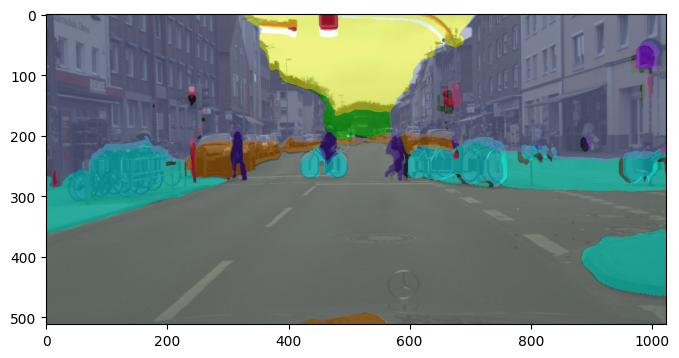

In [ ]:
# Init the model from the config and the checkpoint
cfg = Config.fromfile('configs/dpt/dpt_vit-b16_8xb2-160k_ade20k-512x512.py')
checkpoint_path = 'checkpoints/dpt_vit-b16_512x512_160k_ade20k-db31cf52.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

# test a single image
img = 'demo/demo.png'
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

### Load Example Dataset


In [ ]:
# download and unzip
!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
!tar xf stanford_background.tar.gz

--2023-06-14 10:53:25--  http://dags.stanford.edu/data/iccv09Data.tar.gz
Resolving dags.stanford.edu (dags.stanford.edu)... 171.64.68.10
Connecting to dags.stanford.edu (dags.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14727974 (14M) [application/x-gzip]
Saving to: ‘stanford_background.tar.gz’

stanford_background 100%[===================>]  14.04M  12.6MB/s    in 1.1s    

2023-06-14 10:53:26 (12.6 MB/s) - ‘stanford_background.tar.gz’ saved [14727974/14727974]



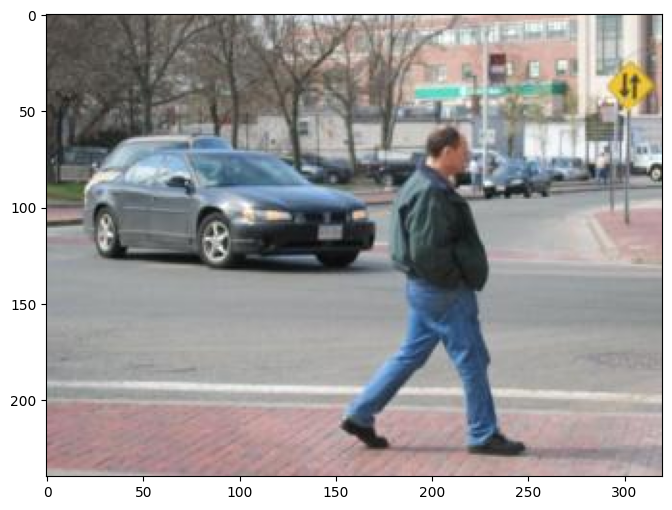

In [ ]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt

img = mmcv.imread('iccv09Data/images/6000124.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34],
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt',
                                                         '.png')))

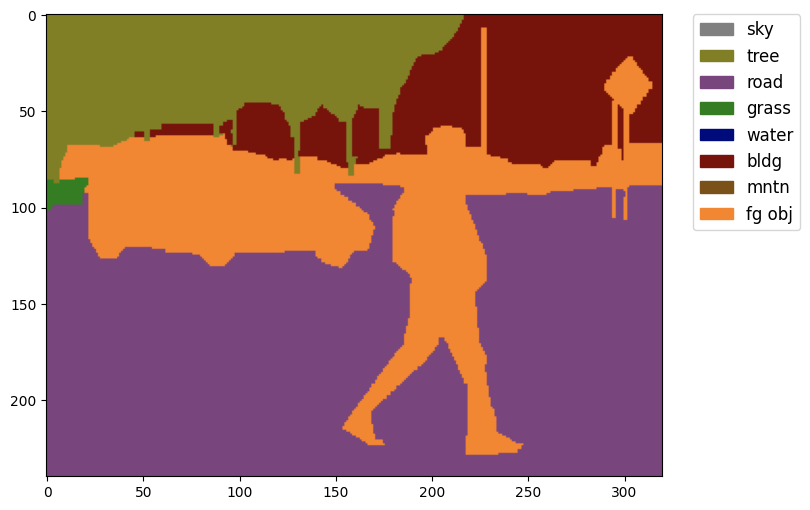

In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(8)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()

In [ ]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)



# Load Eye Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from glob import glob
import zipfile
zip_file = zipfile.ZipFile('/content/gdrive/MyDrive/RTrain5.zip', 'r')
zip_file.extractall('/content/mmsegmentation')

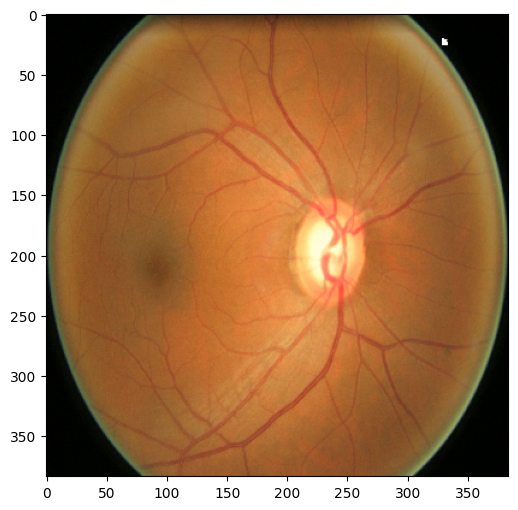

In [ ]:
# Let's take a look at the dataset

img = mmcv.imread('/content/mmsegmentation/RTrain5/images/0.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [ ]:
# convert dataset annotation to semantic segmentation map

data_root = 'RTrain5'
img_dir = 'images'
ann_dir = 'labels'

# define class and plaette for better visualization
classes = ('cup',
           'disc',
           'background')
palette = [[176, 230, 13],
           [0, 151, 219],
           [230, 182, 22]]
for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.txt'):
  seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
  seg_img = Image.fromarray(seg_map).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file.replace('.txt',
                                                         '.png')))

# define class and plaette for better visualization
classes = ('cup',
           'disc')
palette = [[176, 230, 13],
           [0, 151, 219]]
# for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.txt'):
#   seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#   seg_img = Image.fromarray(seg_map).convert('P')
#   seg_img.putpalette(np.array(palette, dtype=np.uint8))
#   seg_img.save(osp.join(data_root, ann_dir, file.replace('.txt',
#                                                          '.png')))

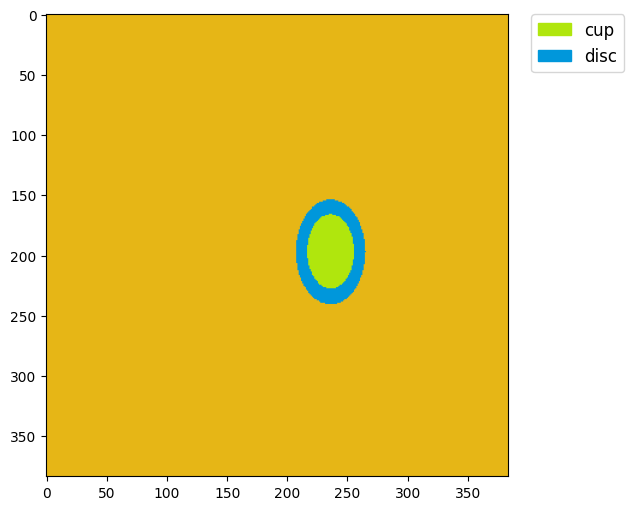

In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('RTrain5/labels/0.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color
patches = [mpatches.Patch(color=np.array(palette[i])/255.,
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
           fontsize='large')

plt.show()

In [ ]:
# split train/val/test
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  f.writelines(line + '\n' for line in filename_list[:520])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[520:585])
with open(osp.join(data_root, split_dir, 'test.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[585:])

After downloading the data, we need to implement load_annotations function in the new dataset class RTrain3
.

In [ ]:
@DATASETS.register_module()
class RTrain5(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

# Eksperiment


In [ ]:
# MAX_ITERATIONS = 20000
# LOG_CONFIG_INTERVAL = 2000
# EVALUATION_INTERVAL = 2000
# CHECKPOINT_CONFIG_INTERVAL = 10000
# BATCH_SIZE = 3

MAX_ITERATIONS = 5000
LOG_CONFIG_INTERVAL = 500
EVALUATION_INTERVAL = 500
CHECKPOINT_CONFIG_INTERVAL = 2500
BATCH_SIZE = 3

# MAX_ITERATIONS = 500
# LOG_CONFIG_INTERVAL = 50
# EVALUATION_INTERVAL = 50
# CHECKPOINT_CONFIG_INTERVAL = 250
# BATCH_SIZE = 3

# MAX_ITERATIONS = 2000
# LOG_CONFIG_INTERVAL = 500
# EVALUATION_INTERVAL = 500
# CHECKPOINT_CONFIG_INTERVAL = 1000
# BATCH_SIZE = 3

DATASET_TYPE = 'RTrain5'
DATA_ROOT = 'RTrain5'
IMAGE_TEST = 'RTrain5/images/0.png'

# Vit-Base

In [ ]:
!python tools/model_converters/vit2mmseg.py https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth pretrain/jx_vit_base_p16_224-80ecf9dd.pth

06/14 10:54:39 - mmengine - INFO - Loads checkpoint by http backend from path: https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth
100% 330M/330M [00:02<00:00, 161MB/s]


In [ ]:
cfg = Config.fromfile('configs/dpt/dpt_vit-b16_8xb2-160k_ade20k-512x512.py')

cfg.dataset_type = DATASET_TYPE
cfg.data_root = data_root

cfg.train_dataloader.batch_size = BATCH_SIZE

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(512, 512), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(512, 512), keep_ratio=True),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/test.txt'

cfg.test_dataloader = cfg.val_dataloader
cfg.test_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.load_from = 'checkpoints/dpt_vit-b16_512x512_160k_ade20k-db31cf52.pth'

cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = MAX_ITERATIONS
cfg.train_cfg.val_interval = LOG_CONFIG_INTERVAL
cfg.default_hooks.logger.interval = EVALUATION_INTERVAL
cfg.default_hooks.checkpoint.interval = CHECKPOINT_CONFIG_INTERVAL

cfg['randomness'] = dict(seed=0)

print(f'Config:\n{cfg.pretty_text}')

cfg_vit_b = cfg

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 512)),
    pretrained=
    '/root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth',
    backbone=dict(
        type='VisionTransformer',
        img_size=224,
        embed_dims=768,
        num_layers=12,
        num_heads=12,
        out_indices=(2, 5, 8, 11),
        final_norm=False,
        with_cls_token=True,
        output_cls_token=True),
    decode_head=dict(
        type='DPTHead',
        in_channels=(768, 768, 768, 768),
        channe

In [ ]:
runner_vit_b = Runner.from_cfg(cfg_vit_b)


06/14 10:56:37 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_

/content/mmsegmentation/mmseg/models/backbones/vit.py:218: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


06/14 10:56:39 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
06/14 10:56:39 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/content/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [ ]:

# start training
runner_vit_b.train()

06/14 10:56:40 - mmengine - INFO - paramwise_options -- backbone.cls_token:lr=6e-05
06/14 10:56:40 - mmengine - INFO - paramwise_options -- backbone.cls_token:weight_decay=0.0
06/14 10:56:40 - mmengine - INFO - paramwise_options -- backbone.cls_token:decay_mult=0.0
06/14 10:56:40 - mmengine - INFO - paramwise_options -- backbone.pos_embed:lr=6e-05
06/14 10:56:40 - mmengine - INFO - paramwise_options -- backbone.pos_embed:weight_decay=0.0
06/14 10:56:40 - mmengine - INFO - paramwise_options -- backbone.pos_embed:decay_mult=0.0
06/14 10:56:41 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loads checkpoint by local backend from path: /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: norm.bias, norm.weight, blocks.0.norm1.bias, blocks.0.norm1.weight, blocks.0.norm2.bias, blocks.0.norm2.weight, blocks.0.mlp.fc1.bias, blocks.0.mlp.fc1.weight, blocks.0.mlp.fc2.bias, blocks.0.mlp.fc2.weight, blocks.0.attn.proj.bias, blocks.0.attn.proj.weight, blocks.0.attn.qkv.bias, blocks.0.attn.qkv.weight, blocks.1.norm1.bias, blocks.1.norm1.weight, blocks.1.norm2.bias, blocks.1.norm2.weight, blocks.1.mlp.fc1.bias, blocks.1.mlp.fc1.weight, blocks.1.mlp.fc2.bias, blocks.1.mlp.fc2.weight, blocks.1.attn.proj.bias, blocks.1.attn.proj.weight, blocks.1.attn.qkv.bias, blocks.1.attn.qkv.weight, blocks.10.norm1.bias, blocks.10.norm1.weight, blocks.10.norm2.bias, blocks.10.norm2.weight, blocks.10.mlp.fc1.bias, blocks.10.mlp.fc1.weight, blocks.10.mlp.fc2.bias, blocks.10.mlp.fc2.weight, blocks.1

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


06/14 10:58:15 - mmengine - INFO - Iter(val) [50/65]    eta: 0:00:02  time: 0.1459  data_time: 0.0053  memory: 10441  
06/14 10:58:18 - mmengine - INFO - per class results:
06/14 10:58:18 - mmengine - INFO - 
+-------+------+-------+
| Class | IoU  |  Acc  |
+-------+------+-------+
|  cup  | 0.47 | 20.15 |
|  disc | 0.99 |  2.2  |
+-------+------+-------+
06/14 10:58:18 - mmengine - INFO - Iter(val) [65/65]    aAcc: 8.7400  mIoU: 0.7300  mAcc: 11.1700  data_time: 0.0077  time: 0.1816
06/14 10:59:26 - mmengine - INFO - Iter(train) [100/500]  lr: 3.9627e-06  eta: 0:10:00  time: 1.3887  data_time: 0.0115  memory: 8949  loss: 2.8915  decode.loss_ce: 2.8915  decode.acc_seg: 81.8502
06/14 10:59:34 - mmengine - INFO - Iter(val) [50/65]    eta: 0:00:02  time: 0.1453  data_time: 0.0051  memory: 2324  
06/14 10:59:36 - mmengine - INFO - per class results:
06/14 10:59:36 - mmengine - INFO - 
+-------+------+-------+
| Class | IoU  |  Acc  |
+-------+------+-------+
|  cup  | 2.73 | 39.55 |
|  di

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (adap_padding): AdaptivePadding()
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (drop_after_pos): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): MultiheadAttention(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (proj_drop): Dropout(p=0.0, inplace=False)
          (dropout_layer): Dropout(p=0.0, inplace=False)
        )
        (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (ffn): FFN(
          (layers): Sequential(
            (0): Sequential(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approxima

In [ ]:
# start validating
runner_vit_b.val()

06/14 11:10:32 - mmengine - INFO - Iter(val) [50/65]    eta: 0:00:02  time: 0.1436  data_time: 0.0023  memory: 2324  
06/14 11:10:35 - mmengine - INFO - per class results:
06/14 11:10:35 - mmengine - INFO - 
+-------+-------+------+
| Class |  IoU  | Acc  |
+-------+-------+------+
|  cup  | 66.55 | 90.7 |
|  disc | 62.03 | 74.8 |
+-------+-------+------+
06/14 11:10:35 - mmengine - INFO - Iter(val) [65/65]    aAcc: 80.6000  mIoU: 64.2900  mAcc: 82.7500  data_time: 0.0033  time: 0.1437


{'aAcc': 80.6, 'mIoU': 64.29, 'mAcc': 82.75}

In [ ]:
# start testing
runner_vit_b.test()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


06/14 11:10:43 - mmengine - INFO - Iter(test) [50/65]    eta: 0:00:02  time: 0.1473  data_time: 0.0023  memory: 2324  
06/14 11:10:45 - mmengine - INFO - per class results:
06/14 11:10:45 - mmengine - INFO - 
+-------+-------+-------+
| Class |  IoU  |  Acc  |
+-------+-------+-------+
|  cup  | 59.13 | 87.48 |
|  disc | 58.09 |  71.4 |
+-------+-------+-------+
06/14 11:10:45 - mmengine - INFO - Iter(test) [65/65]    aAcc: 76.7100  mIoU: 58.6100  mAcc: 79.4400  data_time: 0.0063  time: 0.1511


{'aAcc': 76.71, 'mIoU': 58.61, 'mAcc': 79.44}

/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_500.pth
06/14 11:31:12 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


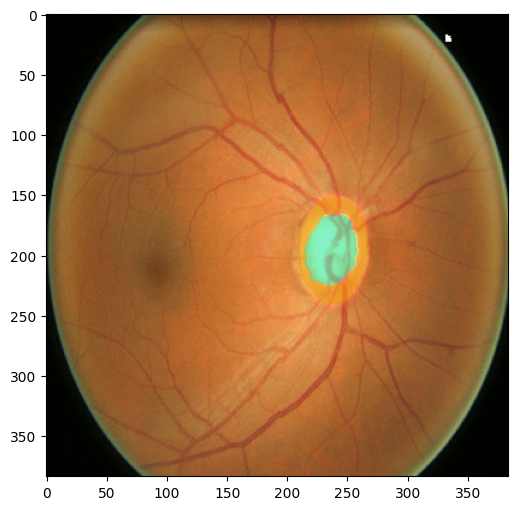

In [ ]:
# Inference Test
checkpoint_path = './work_dirs/tutorial/iter_500.pth'
model_vit_b = init_model(cfg_vit_b, checkpoint_path, 'cuda:0')

img = mmcv.imread(IMAGE_TEST)
result = inference_model(model_vit_b, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model_vit_b, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [ ]:
kumpulan = []
i = 0
for i in range(650) :
  img = mmcv.imread(f'/content/mmsegmentation/RTrain5/images/{i}.png')
  result = inference_model(model_vit_b, img)
# plt.figure(figsize=(8, 6))
  vis_result = show_result_pyplot(model_vit_b, img, result)
  kumpulan.append(vis_result)
  # print(img)
  # plt.imshow(mmcv.bgr2rgb(vis_result))

In [ ]:
len(kumpulan)

650

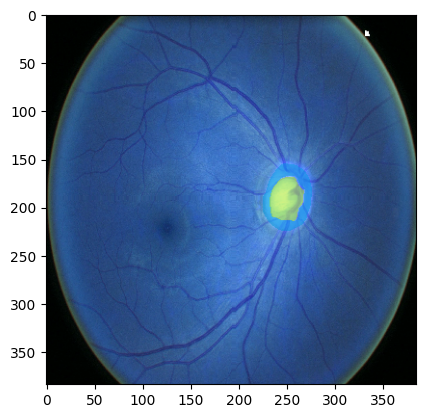

In [ ]:
plt.imshow(kumpulan[3])
plt.show('1.375000')

In [ ]:
kumpulan[0]

array([[[0, 0, 0],
        [0, 1, 1],
        [0, 1, 1],
        ...,
        [0, 3, 1],
        [1, 2, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 1, 1],
        [0, 2, 2],
        ...,
        [0, 3, 1],
        [0, 3, 1],
        [0, 2, 2]],

       [[0, 2, 2],
        [0, 1, 1],
        [0, 0, 0],
        ...,
        [0, 2, 0],
        [0, 2, 0],
        [0, 1, 1]],

       ...,

       [[1, 4, 2],
        [0, 3, 1],
        [0, 3, 1],
        ...,
        [0, 2, 0],
        [0, 2, 0],
        [0, 1, 1]],

       [[1, 4, 2],
        [0, 3, 1],
        [0, 3, 1],
        ...,
        [0, 2, 0],
        [0, 2, 0],
        [0, 1, 1]],

       [[0, 2, 0],
        [0, 2, 0],
        [0, 2, 0],
        ...,
        [0, 2, 0],
        [0, 2, 0],
        [0, 1, 1]]], dtype=uint8)

In [ ]:
R = np.array(kumpulan)

In [ ]:
od = (R==3).astype(np.float32)
oc = (R==4).astype(np.float32)

In [ ]:
oc[3]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 1., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [ ]:
def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.
    '''

    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=0)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter, axis=0)
    diameter = np.average (diameter)

    # return it
    return diameter

In [ ]:
satu = vertical_diameter(oc[2])

print(satu)

20.333334


In [ ]:
dua = vertical_diameter(od[2])

print(dua)

41.666668


In [ ]:
def vertical_cup_to_disc_ratio(od, oc):
    '''
    Compute the vertical cup-to-disc ratio from a given labelling map.
    '''
    EPS = 1e-7
    # compute the cup diameter
    cup_diameter = vertical_diameter(oc)
    # compute the disc diameter
    disc_diameter = vertical_diameter(od)

    return cup_diameter / (disc_diameter+EPS)

In [ ]:
jumlah = []
i = 0
j=0

In [ ]:
for i in range(len(oc)):
    hasil = vertical_cup_to_disc_ratio(od[i],oc[j])
    # hasil = (hasil[0]+hasil[1]+hasil[2])/3
    # print(hasil)
    jumlah.append(hasil.tolist())
    i = i +1
    j=j+1

In [ ]:
import pandas as pd
df = pd.DataFrame(jumlah, columns=['Vcdr'])
df

,Vcdr
0,0.519084
1,0.531532
2,0.488000
3,0.496503
4,0.729730
...,...
645,0.555556
646,0.640000
647,0.621053
648,0.802632


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

tsh =  0.63
# while tsh < 1:
predicted = []
for row in df['Vcdr']:
  if row >= tsh:
    predicted.append(1)
  else:
    predicted.append(0)
df['Vcdr_label'] =  predicted
    # print(f"treshold = {tsh:.2f}, accuracy  : {accuracy_score(df['label'], df['Vcdr_label']):.3f}")

In [ ]:
df['No'] = np.arange(len(df))
df = df[['No','Vcdr', 'Vcdr_label']]

In [ ]:
df

,No,Vcdr,Vcdr_label
0,0,0.519084,0
1,1,0.531532,0
2,2,0.488000,0
3,3,0.496503,0
4,4,0.729730,1
...,...,...,...
645,645,0.555556,0
646,646,0.640000,1
647,647,0.621053,0
648,648,0.802632,1


In [ ]:
import pandas as pd

data_xl_origa = '/content/gdrive/MyDrive/df_all.xlsx'


In [ ]:
df_650 = pd.read_excel(data_xl_origa)
df_650

,Unnamed: 0,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label
0,0,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7097,0.636027,0.580909,0
1,1,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6953,0.575024,0.608413,0
2,2,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.9629,0.299303,0.262828,0
3,3,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7246,0.503186,0.483273,0
4,4,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6138,0.500141,0.283467,0
...,...,...,...,...,...,...,...,...
645,645,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6560,0.123190,0.264288,1
646,646,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7365,0.602515,0.528356,1
647,647,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.5101,0.295414,0.549101,1
648,648,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.5227,0.624191,0.383839,0


In [ ]:
df_actual = pd.concat([df_650])

df_actual ['CDR Predicted'] = df['Vcdr']
df_actual ['Label Predicted'] = df['Vcdr_label']

In [ ]:
df_actual

,Unnamed: 0,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label,CDR Predicted,Label Predicted
0,0,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7097,0.636027,0.580909,0,0.519084,0
1,1,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6953,0.575024,0.608413,0,0.531532,0
2,2,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.9629,0.299303,0.262828,0,0.488000,0
3,3,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7246,0.503186,0.483273,0,0.496503,0
4,4,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6138,0.500141,0.283467,0,0.729730,1
...,...,...,...,...,...,...,...,...,...,...
645,645,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.6560,0.123190,0.264288,1,0.555556,0
646,646,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.7365,0.602515,0.528356,1,0.640000,1
647,647,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.5101,0.295414,0.549101,1,0.621053,0
648,648,/content/drive/My Drive/ForKaggle/Cropped_Data...,Origa,True,0.5227,0.624191,0.383839,0,0.802632,1


In [ ]:
df_actual.to_csv('/content/sample_data/df_all3.csv')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(df_actual['Label'], df['Vcdr_label'], target_names=['Normal', 'Glukoma']))

              precision    recall  f1-score   support

      Normal       0.76      0.70      0.73       482
     Glukoma       0.29      0.35      0.32       168

    accuracy                           0.61       650
   macro avg       0.52      0.53      0.52       650
weighted avg       0.64      0.61      0.62       650



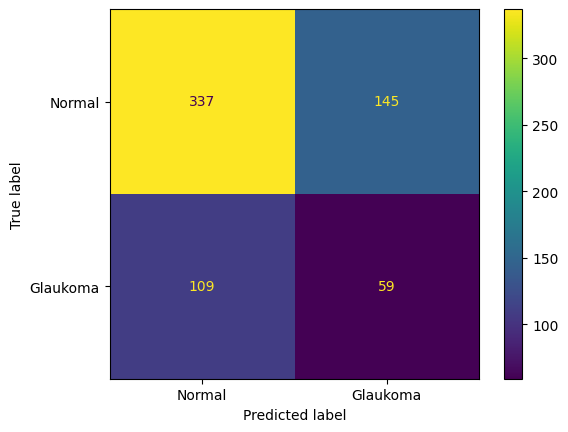

In [ ]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(df_actual['Label'], df['Vcdr_label'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Normal", "Glaukoma"])

cm_display.plot()
plt.show()